In [12]:
# Data Processing
import pandas as pd
import numpy as np
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
# Scaling
from sklearn.preprocessing import StandardScaler
# Statistical Analysis
from scipy import stats
# Modeling
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 

import warnings 
warnings.filterwarnings("ignore")

### EDA

In [2]:
orig_url = "https://drive.google.com/file/d/15pRixHlHOxnx6qixvMSY_zyUfYUr48TA/view?usp=sharing"
file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
df = pd.read_csv(dwn_url)
print(df.shape)
df.head()

(8500, 18)


,customer_id,balance_account,purchases_amount,paid_advance,full_purchases,balance_frequency_update,installments,purchases_frequency,full_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,nr_cash_advances,nr_purchases,credit_limit,fixed_rate_period,payments,min_payments,full_payment_prc
0,tGEg8fT2eCgVxdwS,9.298409,107.60,0.000000,0.00,0.909091,107.6,0.909091,0.000000,0.818182,0.000000,0,10,1000.0,11,89.868853,89.711672,0.428571
1,stEDu20sSKOXomjg,52.666422,150.30,0.000000,0.00,1.000000,150.3,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,6,54.722514,82.955180,0.000000
2,CEB2blrN3b88GsRe,1360.795674,0.00,462.861443,0.00,1.000000,0.0,0.000000,0.000000,0.000000,0.272727,6,0,1500.0,11,303.031979,443.781316,0.000000
3,0N0eBl8ySaZThxKE,2021.641161,363.18,0.000000,363.18,1.000000,0.0,1.000000,1.000000,0.000000,0.000000,0,13,2000.0,12,704.240770,795.859808,0.000000
4,6NLauoHUwtwOv4Wy,22.322374,95.00,1162.045833,95.00,0.363636,0.0,0.083333,0.083333,0.000000,0.166667,3,1,2500.0,12,4094.261427,40.142262,0.000000


In [5]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix as a heatmap using Plotly
fig = px.imshow(corr_matrix.values,
                x=list(corr_matrix.columns),
                y=list(corr_matrix.index),
                color_continuous_scale="RdBu",
                zmin=-1,
                zmax=1,
                labels=dict(x="Features", y="Features", color="Correlation"),
                width=700, height=700)
fig.show()

In [6]:
def outlier_percentage(data):
    '''
    This function calculates the percentage of outlier in a dataset.
    '''
    quantile_1 = data.quantile(0.25)
    quantile_3 = data.quantile(0.75)
    IQR = quantile_3 - quantile_1
    lower_treshold = quantile_1 - (1.5 * IQR)
    upper_threshold = quantile_3 + (1.5 * IQR)
    num_outliers =  np.sum((data < lower_treshold) |(data > upper_threshold))
    outliers =  ((data < lower_treshold) |(data > upper_threshold))
    num_data = data.count()
    return (num_outliers/num_data)*100

In [8]:
def show_outlier(data):
    '''
    This function shows the percentage of outlier in each numerical column.
    '''
    for column in data.columns:
        data_section = data[column]
        percent = str(round(outlier_percentage(data_section), 2))
        print(f'Outlier in column "{column}": {percent}%')
        
non_categorical_data = df.drop(['customer_id'], axis=1)
show_outlier(non_categorical_data)

Outlier in column "balance_account": 7.82%
Outlier in column "purchases_amount": 8.94%
Outlier in column "paid_advance": 11.56%
Outlier in column "full_purchases": 11.34%
Outlier in column "balance_frequency_update": 16.53%
Outlier in column "installments": 9.8%
Outlier in column "purchases_frequency": 0.0%
Outlier in column "full_purchases_frequency": 10.47%
Outlier in column "purchases_installments_frequency": 0.0%
Outlier in column "cash_advance_frequency": 5.89%
Outlier in column "nr_cash_advances": 9.07%
Outlier in column "nr_purchases": 8.44%
Outlier in column "credit_limit": 2.34%
Outlier in column "fixed_rate_period": 15.35%
Outlier in column "payments": 8.88%
Outlier in column "min_payments": 9.8%
Outlier in column "full_payment_prc": 16.32%


In [10]:
non_categorical_data.isnull().sum()

customer_id                           0
balance_account                       0
purchases_amount                      0
paid_advance                          0
full_purchases                        0
balance_frequency_update              0
installments                          0
purchases_frequency                   0
full_purchases_frequency              0
purchases_installments_frequency      0
cash_advance_frequency                0
nr_cash_advances                      0
nr_purchases                          0
credit_limit                          1
fixed_rate_period                     0
payments                              0
min_payments                        298
full_payment_prc                      0
dtype: int64

In [9]:
# Drop rows with missing credit_limit values
non_categorical_data.dropna(subset=["min_payments"], inplace=True)

In [11]:
# Drop rows with missing credit_limit values
non_categorical_data.dropna(subset=["credit_limit"], inplace=True)

Scaling

In [13]:
df_scaled = pd.DataFrame(StandardScaler().fit_transform(non_categorical_data), columns=non_categorical_data.columns)

In [14]:
z = np.abs(stats.zscore(df_scaled))
df_scaled_out = df_scaled[(z < 3).all(axis=1)]
df_scaled_out.shape

(6837, 17)

### PCA

In [16]:
pca = PCA(random_state=42).fit(df_scaled_out)
pca_data = pca.transform(df_scaled_out) 
pca_labels = ['PC' + str(component) for component in range(1,len(pca.components_)+1)]
pca_df = pd.DataFrame(pca_data, columns=pca_labels)
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
0,1.200502,-1.498938,-1.079815,0.282603,-0.605674,0.032838,0.616916,-0.319693,0.247954,0.243035,0.333769,-0.112889,0.037856,-0.026211,0.046476,0.068437,-0.000168
1,-2.072662,-0.068631,-0.396241,-0.292974,-0.796504,0.140276,0.309070,0.277091,-0.229177,-0.444645,0.058167,0.106117,0.092901,-0.024981,0.108021,-0.060621,-0.000096
2,1.003132,0.827245,1.350771,-2.016799,-0.770346,0.481279,0.185326,-1.031601,0.940681,0.351919,-0.618222,0.465472,-0.359481,-0.137768,0.116383,0.293215,-0.000055
3,-1.734307,-1.335524,1.082555,0.576679,1.113257,1.525052,-0.773932,0.086273,-0.067143,0.604799,0.035768,0.505528,0.217835,-0.167438,-0.033823,0.019076,-0.000268
4,-1.022459,0.037667,0.830273,-0.430174,1.162408,-1.774325,0.524558,-0.488835,-1.510350,-0.106421,-0.103088,0.015654,0.105739,0.380332,-0.052854,-0.023669,-0.000150


In [17]:
explained_var_ratio_per_PCA = np.round(pca.explained_variance_ratio_ * 100, decimals=1) 
explained_var_ratio_per_PCA_df = pd.DataFrame(pca.explained_variance_ratio_ * 100, index= pca_labels)
explained_var_ratio_per_PCA_df.head()

,0
PC1,32.245087
PC2,18.214374
PC3,11.570303
PC4,9.260859
PC5,6.746301


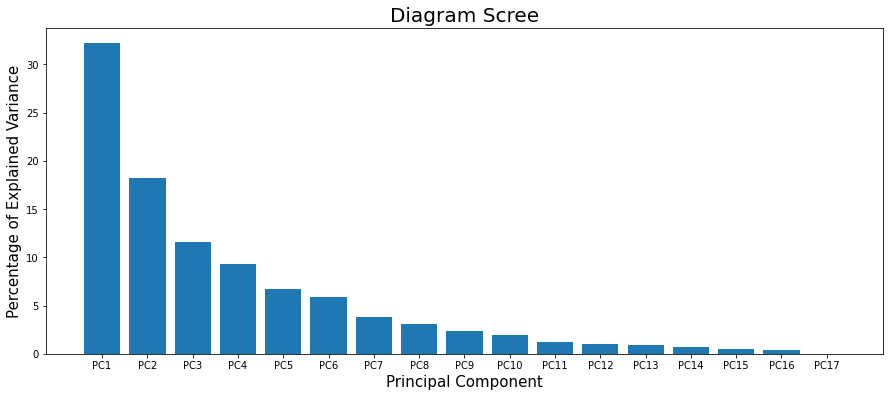

In [19]:
fig = plt.figure(figsize=(15,6))
plt.bar(x=range(1, len(explained_var_ratio_per_PCA)+1), height=explained_var_ratio_per_PCA, tick_label=pca_labels)
plt.ylabel('Percentage of Explained Variance', fontsize=15)
plt.xlabel('Principal Component', fontsize=15)
plt.title('Diagram Scree', fontsize=20)
plt.show()

In [21]:
print(f"Total variation explained by PC1 and PC2 is :{pca.explained_variance_ratio_[:2].sum()*100}")

Total variation explained by PC1 and PC2 is :50.45946105726793


In [22]:
pca_clusters = pd.DataFrame(pca_df[['PC1','PC2']])

### K-Mean clustering

In [23]:
k_means_clusters = KMeans(n_clusters=3,random_state=8).fit(pca_clusters)
cluster_center = k_means_clusters.cluster_centers_
cluster_preds = k_means_clusters.predict(pca_clusters)

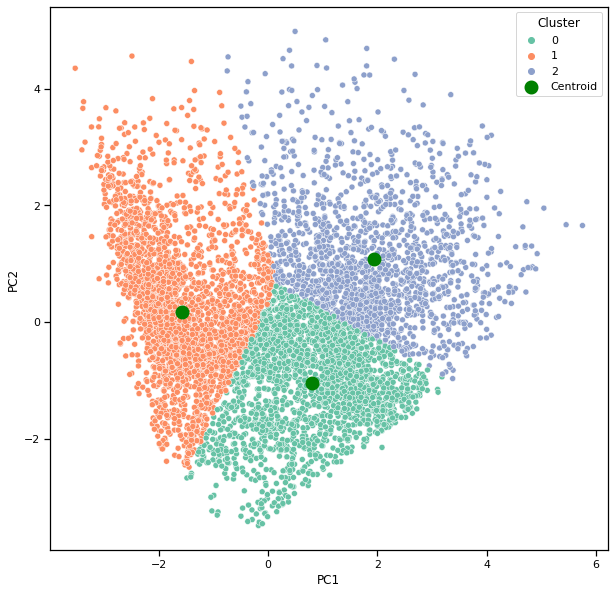

In [24]:
pca_clusters['cluster'] = cluster_preds

plt.figure(figsize=(10,10))
sns.set_context(context = 'notebook', font_scale=1)

sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'cluster', data = pca_clusters, palette='Set2')
plt.scatter(cluster_center[:,0],cluster_center[:,1], marker = "o", s=80, linewidths = 5, zorder = 10, c='green',label="Centroid")

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title="Cluster")
plt.show()

In [26]:
df_copy = df_scaled_out.copy()
df_copy['cluster'] = cluster_preds
df_copy['cluster'].value_counts()

1    3061
0    2172
2    1604
Name: cluster, dtype: int64

In [29]:
from google.colab import files

df_copy.to_csv('cred_card_ready.csv', index=False)
files.download('cred_card_ready.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
def make_radar_chart(dataset, title):

    mean_feature_per_cluster = dataset.groupby("cluster").mean().to_numpy()
    name_feature = dataset.columns[0:-1]
    categories = np.arange(0, len(mean_feature_per_cluster))
    
    fig = go.Figure()

    for i in range(len(mean_feature_per_cluster)):
      fig.add_trace(go.Scatterpolar(
          r=mean_feature_per_cluster[i],
          theta=name_feature,
          name=f'class {categories[i]}'
      ))

    fig.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[np.min(mean_feature_per_cluster), np.max(mean_feature_per_cluster)]
        )),
      showlegend=True,
      width = 1200,
      height = 720,
      title = dict(text = f'Feature comparison ({title})\n',
                   font=dict(size=20))
    )

    fig.show()

make_radar_chart(df_copy, 'Credit Card Dataset')